### Bonus Task for HW4

### Done by Vladislav Gromadskii

In [1]:
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
import torch.nn.init as init
from torch.utils.data import Sampler
from torch.utils.data import Dataset, DataLoader
import sys

from tqdm import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Network from seminar

In [2]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size
    


class PositionalEmbedding(nn.Module):
    def __init__(self, size: int, type: str, **kwargs):
        super().__init__()

        self.layer = SinusoidalEmbedding(size, **kwargs)

    def forward(self, x: torch.Tensor):
        return self.layer(x)
        
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))
    
class DiffModel(nn.Module):
    def __init__(self, d_in, num_emb=2):
        super().__init__()

        self.hidden = 128
        self.x_proj = PositionalEmbedding(self.hidden, "sinusoidal", scale=25.0)
        self.t_proj = PositionalEmbedding(self.hidden, "sinusoidal")


        layers = [
            nn.Linear(self.hidden * (num_emb + 1), self.hidden),
            nn.GELU()
        ]

        for _ in range(4):  # 4 hidden layers, it was 3 in the seminar implementation
            layers.append(Block(self.hidden))

        layers.append(nn.Linear(self.hidden, d_in))

        self.layers = nn.Sequential(*layers)


    def forward(self, x, t):
        '''
        :x input, e.g. images
        :t 1d torch.LongTensor of timesteps
        '''
        x_emb = torch.cat([self.x_proj(x[:, i]) for i in range(x.shape[1])], dim=-1)
        t_emb = self.t_proj(t); t_emb = self.t_proj(t).squeeze(1)
        x = torch.cat([x_emb, t_emb], dim=-1)
        return self.layers(x)


## Datasets and Samplers

8 Gaussians and 2 Moons

In [3]:
def eight_normal_sample(batch_size, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((batch_size,))
    multi = torch.multinomial(torch.ones(8), batch_size, replacement=True)
    data = []
    for i in range(batch_size):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data

def sample_8gaussians(batch_size = 100):
    return eight_normal_sample( batch_size, 2 , scale=5, var=0.1).float()

def sample_moons(batch_size = 100):
    moon_data, _ = make_moons(n_samples=batch_size, noise=0.05)
    # Scale and shift the moons to match the scale of the Gaussian data
    return torch.tensor(moon_data * 3 - 1).float()

## Train function and ODE Solver

In [4]:
def train_velocity( vnet, epoches = 1000, batch_size = 64, l_r = 1e-3):
    """
    Velocity/Vector field network training from 8 Gaussian to 2 Moons
    """
    sig_min = 0.001
    
    #Optimizer 
    vnet_opt = torch.optim.Adam(vnet.parameters(), lr=l_r)

    loss_arr = []

    for i in tqdm(range(epoches)):
        
        # Sample data from datasets and t from uniform
        t = torch.rand(size=(batch_size, 1)) #Sample t ~ Uniform(0,1)
        x_0 = sample_8gaussians(batch_size=batch_size) 
        x_1 = sample_moons(batch_size=batch_size)
       
        #Calculate x_t
        x_t = t * x_1 + (1. - (1 - sig_min) * t) * x_0 

        #=======
        v_target = x_1 - (1-sig_min) *x_0

        predicted_v = vnet(x_t, t)
        
        #Loss 
        loss_function = nn.MSELoss()
        loss = loss_function(predicted_v, v_target)

        loss_arr.append(loss.item())
        
        vnet_opt.zero_grad(); loss.backward(); vnet_opt.step()

    return loss_arr

In [5]:
class ODE_Solver(nn.Module):
    def __init__(self, steps=100, start_t = 0, end_t = 1):
        """
        ODE solver with Euler Method
        """
        super().__init__()
        self.start_t = start_t
        self.end_t = end_t
        self.steps = steps #number of steps for time discretization
        self.delta_t = float((self.end_t-self.start_t)) / steps #since time has values in range [start_t, end_t]
        


    def get_velocity(self, x, t, vnet):
        
        with torch.no_grad():

            return vnet(x, t)

        

    def solve_euler(self, x, vnet, printable=True):
        """
        Euler method

        Args:
            x (Tensor [BS, N=2]): initial distribution to be mapped.
            vnet : neural network approximation of velocity/drift function.

        Returns:
            trajectory_torched (Tensor [BS, steps, N=2]): trajectory of points.
            prediction (Tensor [BS, N=2]): mapped distribution.
        """
        batch_size = x.shape[0]
        t = torch.zeros((batch_size,1)) #Torch Tensor filled with 0s shape [BS, 1]

        trajectory = [x]

        for step in range (self.steps):
            
                velocity = self.get_velocity(x, t, vnet)
            
                x = x + velocity * self.delta_t
                t+= self.delta_t

                trajectory.append(x)
        
        trajectory_torched = torch.stack(trajectory, dim=1)
        prediction = trajectory_torched[:,-1,:]

        if printable==True:
            return trajectory_torched.detach().cpu(), prediction.detach().cpu()
        else:
            return trajectory_torched, prediction

## Global Params

In [6]:
#=====
#Data params
DATA_N = 1000 #number of points to be plotted and mapped 

#=====
#Training params

L_R = 1e-3
EPOCHES = 6000
BATCH_SIZE = 128


#======
#ODE Euler solver params
STEPS = 100 #Steps for time discretization in Euler method

## Vector field model Training

In [7]:
Unet = DiffModel(d_in=2)
loss_arr_unet = train_velocity(Unet, batch_size=BATCH_SIZE,epoches=EPOCHES, l_r=L_R)


100%|██████████| 6000/6000 [00:25<00:00, 233.98it/s]


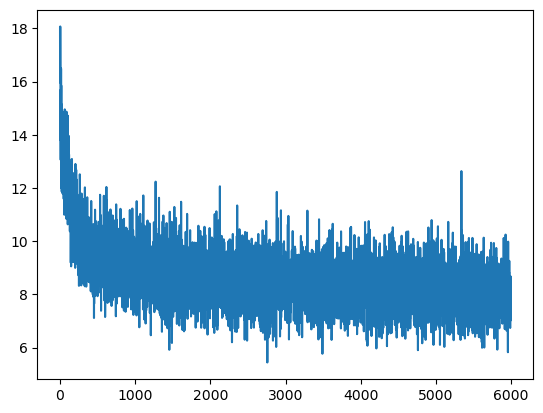

In [8]:
plt.plot(list(range(EPOCHES)), loss_arr_unet)

## Plot Results

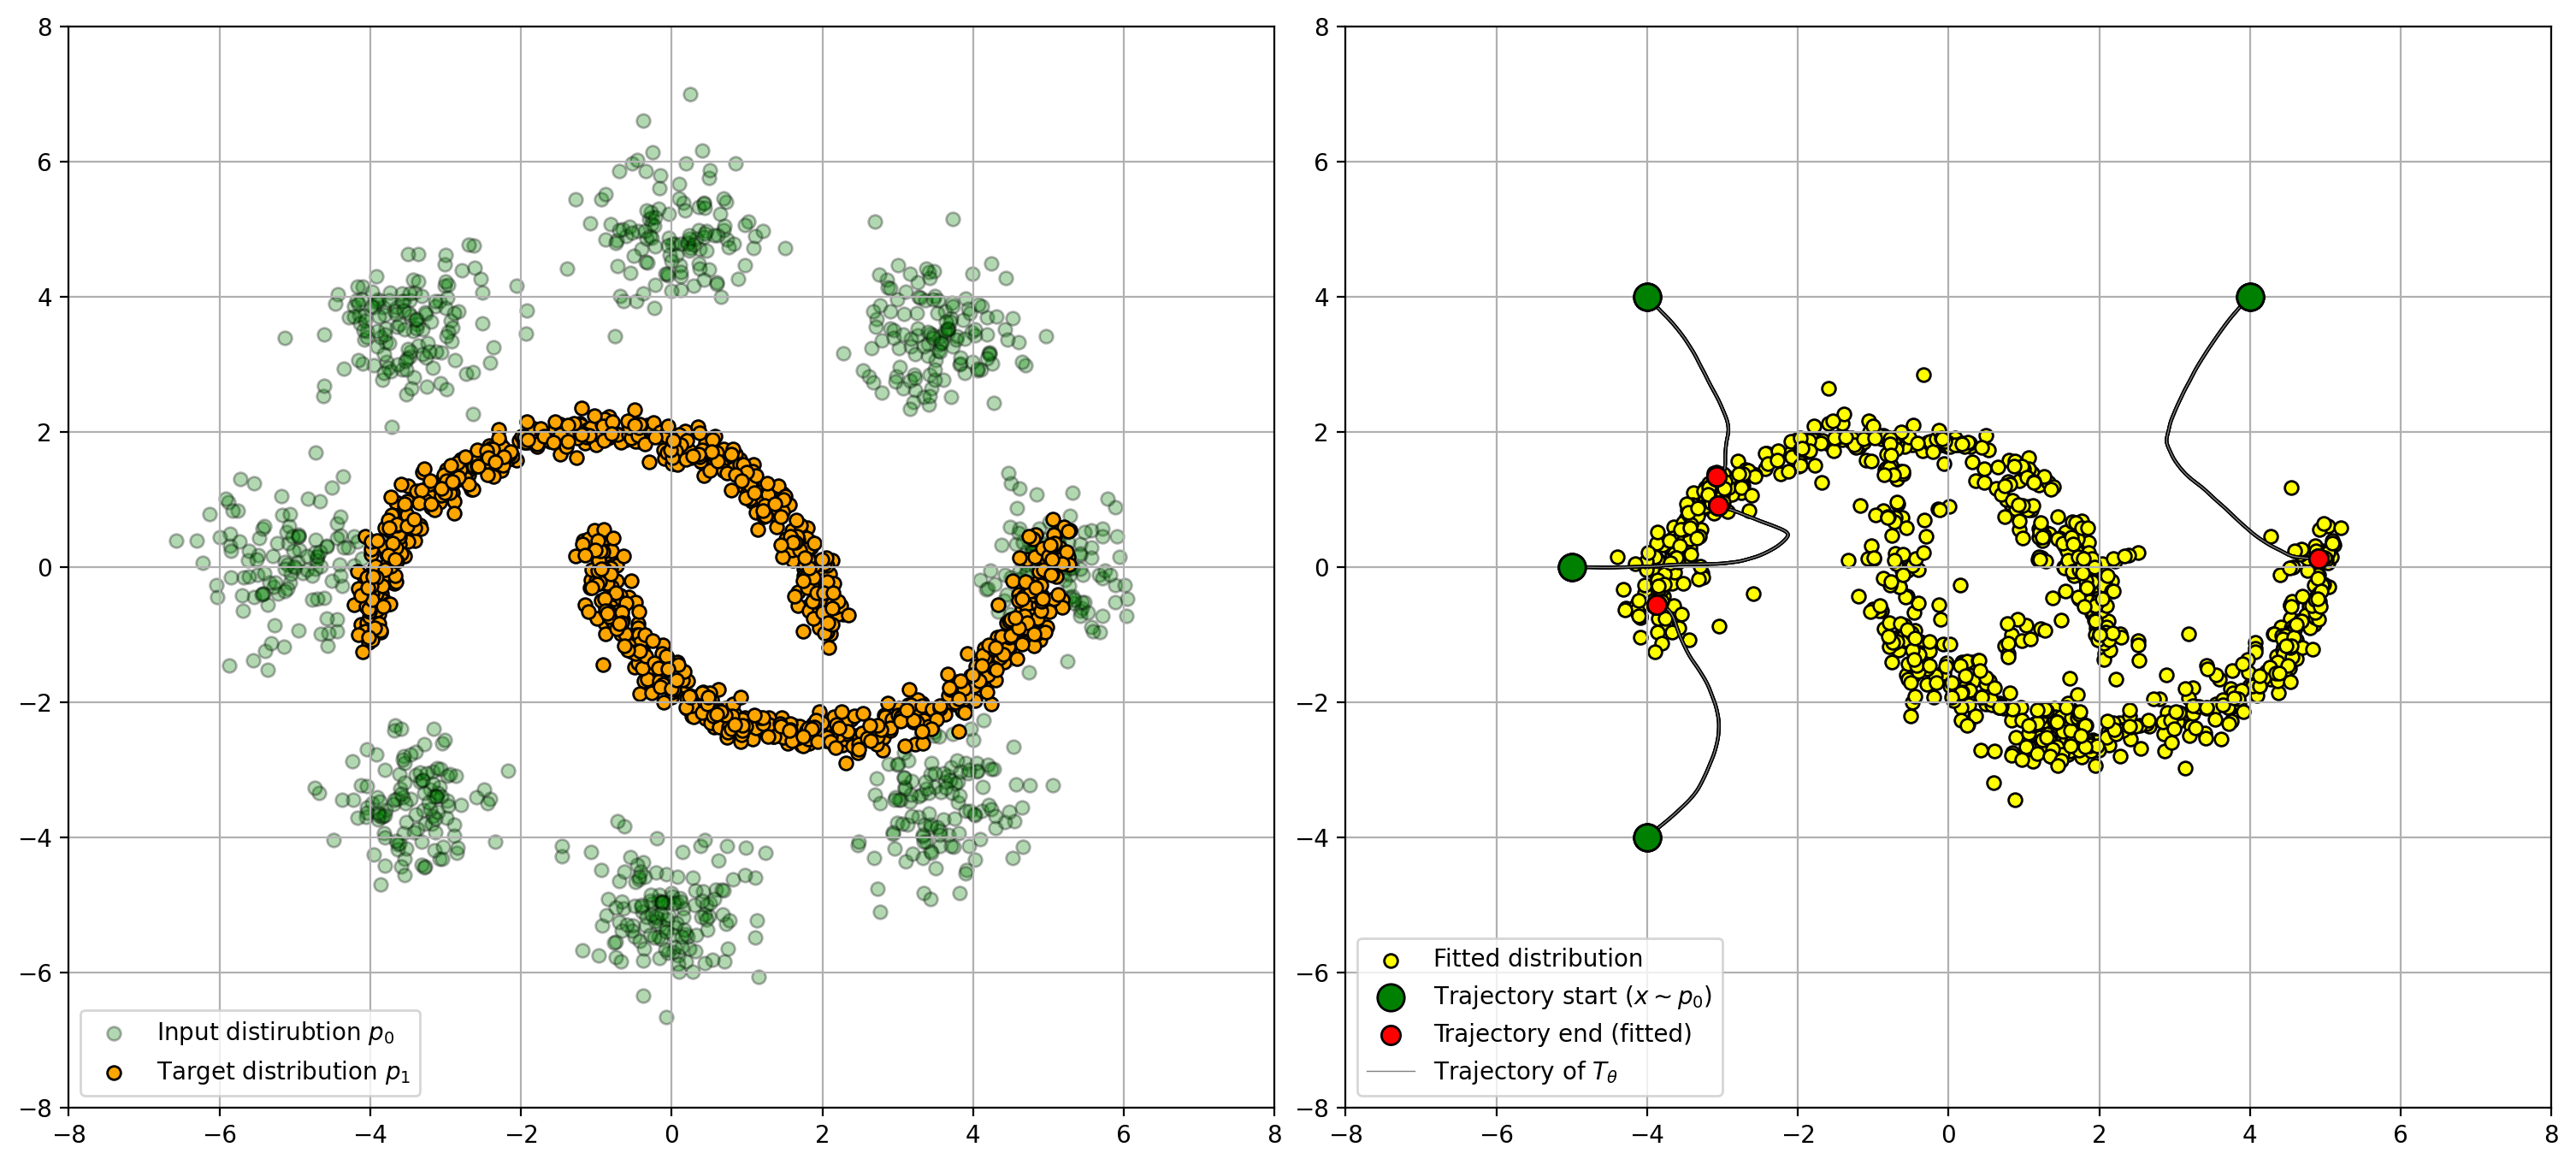

In [9]:
import matplotlib.pyplot as plt

#Define solver
solver = ODE_Solver(steps=STEPS)


fig, axes = plt.subplots(1, 2, figsize=(15, 6.75), dpi=200)

for ax in axes:
    ax.grid(zorder=-20)

#====
#Data
x_samples = sample_8gaussians(DATA_N)
y_samples= sample_moons(DATA_N)

tr_samples = torch.tensor([[-4, 4], [-4, -4], [4, 4], [-5, 0]])
tr_samples = tr_samples[None].repeat(3, 1, 1).reshape(12, 2)#12 not 4    3 not 1

#Use solve method of SDE_Solver to get trajectory and mapped distribution
trajectory, y_pred = solver.solve_euler(x_samples, Unet)
trajectory_example, pred_example = solver.solve_euler(tr_samples, Unet)


axes[0].scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.3, 
                c="g", s=32, edgecolors="black", label = r"Input distirubtion $p_0$")
axes[0].scatter(y_samples[:, 0], y_samples[:, 1], 
                c="orange", s=32, edgecolors="black", label = r"Target distribution $p_1$")

ax.scatter(y_pred[:, 0], y_pred[:, 1], 
           c="yellow", s=32, edgecolors="black", label = "Fitted distribution", zorder=1)


ax.scatter(tr_samples[:, 0], tr_samples[:, 1], 
   c="g", s=128, edgecolors="black", label = r"Trajectory start ($x \sim p_0$)", zorder=3)

ax.scatter(trajectory_example[:, -1, 0], trajectory_example[:, -1, 1], 
   c="red", s=64, edgecolors="black", label = r"Trajectory end (fitted)", zorder=3)

for i in range(12):
    ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "black", markeredgecolor="black",
         linewidth=1.5, zorder=2)
    if i == 0:
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2, label=r"Trajectory of $T_{\theta}$")
    else:
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2)

for ax in axes:
    ax.set_xlim([-8, 8])
    ax.set_ylim([-8, 8])
    ax.legend(loc="lower left")

fig.tight_layout(pad=0.5)

In [19]:
from matplotlib.collections import LineCollection
def plot_trajectories(x_0, x_ts, n_samples, step=1):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(x_0[:, 0], x_0[:, 1], s=1, c='green', label='Start')
    ax.scatter(x_ts[-1][:, 0], x_ts[-1][:, 1], s=1, c='orange', label='End')

    total_steps = (len(x_ts) - step - 1) // step
    lines = []

    with tqdm(total=n_samples, desc="Preparing trajectories") as pbar:
        for sample_i in range(n_samples):
            sample_lines = []
            for t in range(0, len(x_ts) - step - 1, step):
                sample_lines.append([
                    (x_ts[t][sample_i, 0].item(), x_ts[t][sample_i, 1].item()),
                    (x_ts[t + step][sample_i, 0].item(), x_ts[t + step][sample_i, 1].item())
                ])
            lines.extend(sample_lines)
            pbar.update(1)

    print("Plotting trajectories...")
    lc = LineCollection(lines, colors='green', alpha=0.1)
    ax.add_collection(lc)

    ax.legend()
    ax.set_title("Trajectories from 8 Gaussians to 2 Moons")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.show()

Plotting all trajectories

Preparing trajectories: 100%|██████████| 1000/1000 [00:00<00:00, 1407.17it/s]


Plotting trajectories...


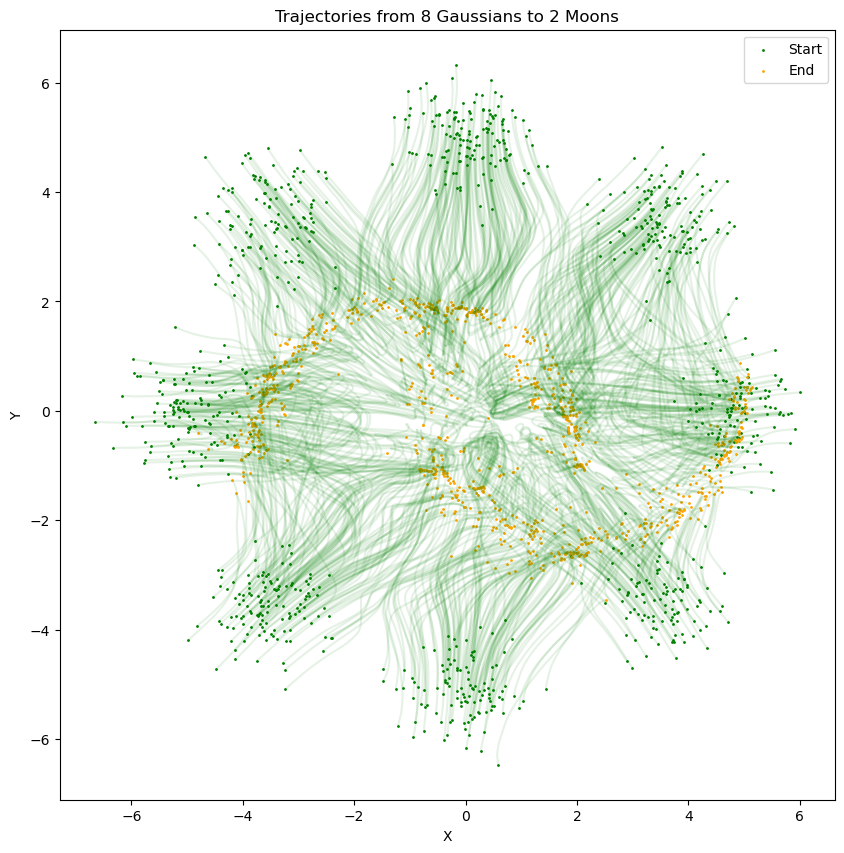

In [20]:

n_samples = 1000
x_0 = sample_8gaussians(batch_size=n_samples)

trajectory_torched, prediction = solver.solve_euler(x_0, Unet)

# Convert to list of tensors for plotting
x_ts = [trajectory_torched[:, i, :] for i in range(trajectory_torched.shape[1])]

# Plot
plot_trajectories(x_0, x_ts, n_samples)